In [ ]:
def max_pwr(self, obj, min_pwr=20.0):
    snr, freq, rng = self.get_objcontents(obj['rngfreq']['indices'])
    max_pwr = snr.max(axis=1)
    max_pwr_i = snr.argmax(axis=1) # index into the rng vector
    over_thresh = max_pwr >= min_pwr # the freqs at which the max power exceeds min_pwr
     
    max_pwr_freq_i, max_pwr_rng_i = np.unravel_index(snr.argmax(), snr.shape)
    
    max_pwr_dict = {'freq': freq[over_thresh], 'rng':rng[max_pwr_i][over_thresh], 'max_pwr':max_pwr[over_thresh],
                   'max_pwr_freq': freq[max_pwr_freq_i], 'max_pwr_rng': rng[max_pwr_rng_i],
                   'max_pwr_val': max_pwr[over_thresh].max()}
    
    return max_pwr_dict

In [ ]:
i=14

vip = vp(os.path.join('netcdf',test_file_list[i]+'.NGI'))
ann = ad.annotationtodict(test_file_list[i],'resnet_train')
objs = vip.get_objects(detection_model, thresh=0.5)
mp = max_pwr(vip, objs[0])

In [ ]:
fig = plt.figure(figsize=(12,8), frameon=False)
ax = fig.subplots(1,2)

image = plt.imread(os.path.join('images_png',test_file_list[i]+'_SNR.PNG'))
ax[0].imshow(image, aspect='auto')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
for f in ['top','right','bottom','left']:
    ax[0].spines[f].set_visible(False)

show_objects(vip, objs, true_bbox=ann['bndbox'], ax=ax[1])

plt.tight_layout()fig = plt.figure(figsize=(12,8), frameon=False)
ax = fig.subplots(1,2)

show_objects(vip, objs, ax=ax[0])

ax[1].plot(mp['freq'], mp['rng'], '.', color='white', label='Max Power')
show_objects(vip, objs, ax=ax[1])


In [ ]:
fig = plt.figure(figsize=(12,8), frameon=False)
ax = fig.subplots(1,2)

show_objects(vip, objs, ax=ax[0])

ax[1].plot(mp['freq'], mp['rng'], '.', color='white', label='Max Power')
show_objects(vip, objs, ax=ax[1])


In [45]:
import matplotlib.lines as mlines

def critfreq_fit(self, obj, ax):
    mp = max_pwr(self, obj)
    
    X = mp['freq'].reshape(-1,1)
    Y = 1.0/mp['rng']
    reg = LinearRegression().fit(X,Y)
    fitted = reg.predict(X)
    
    critfreq = (-1.0*reg.intercept_)/reg.coef_[0]
    
    ax.plot(X, fitted, color='red', linewidth=5, label='fitted')
    ax.scatter(X, Y, marker='o', color='blue', label='1/h\'(f)')

    
    ax.set_title(f'Station: {vip.station}\nDateTime: {vip.obs_time}',
                fontdict={'size':16, 'weight':'bold'})
    
    ax.set_xlabel('Freqency (kHz)')
    ax.set_ylabel('Inverse Virtual Height')
    
    textstr = 'Critical Freq\n %.2f kHz\n\n $R^2$: %.4f' %(critfreq,reg.score(X,Y))
    ax.text(1.05, 0.75, textstr,transform=ax.transAxes,
           fontdict={'size':16, 'weight':'bold'},
           bbox={'edgecolor':'black', 'facecolor':'none'})
    ax.legend(fontsize='large')
    ax.grid()
    

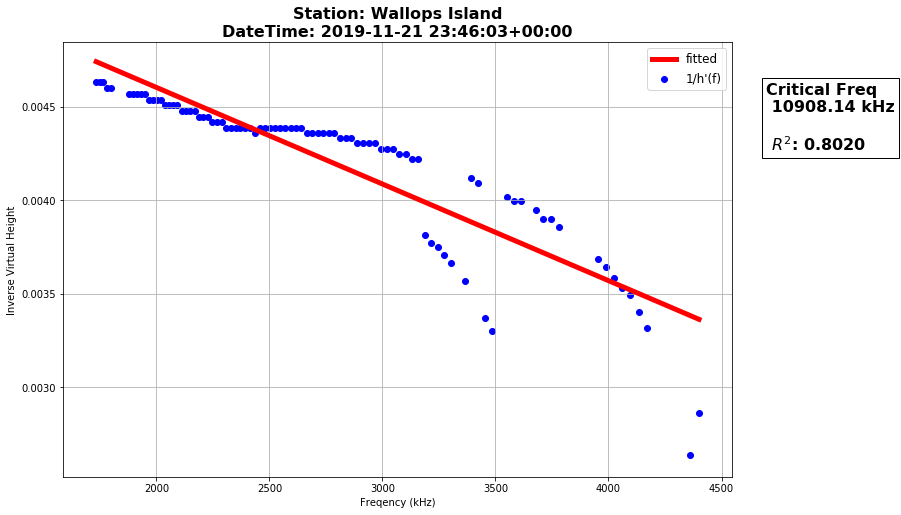

In [46]:
fig = plt.figure(figsize=(12,8))
ax = fig.subplots(1,1)
critfreq_fit(vip,objs[0], ax)

In [47]:
mp.keys()

dict_keys(['freq', 'rng', 'max_pwr', 'max_pwr_freq', 'max_pwr_rng', 'max_pwr_val'])

In [48]:
def add_pwrstats_ax(ax, pwr):
    
    max_pwr_freq = pwr['max_pwr_freq']
    max_pwr_rng = pwr['max_pwr_rng']
    max_pwr = pwr['max_pwr_val']
    
    max_rng = pwr['rng'].max()
    max_rng_i = pwr['rng'].argmax()
    max_rng_freq = pwr['freq'][max_rng_i]
    max_rng_pwr = pwr['max_pwr'][max_rng_i]
    
    textstr = (f'Max Pwr Freq: {max_pwr_freq/1000.0:.2f} MHz'
               f'\nMax Pwr Height: {max_pwr_rng:.2f} km'
               f'\nMax Pwr: {max_pwr:.2f} dB'
               f'\n\nMax Height: {max_rng:.2f} km'
               f'\nMax Height Freq: {max_rng_freq/1000.0:.2f} MHz'
               f'\nMax Height Pwr: {max_rng_pwr:.2f} dB'
              )
    
    ax.text(1.025, 0.60, textstr,transform=ax.transAxes,
           fontdict={'size':16, 'weight':'bold'},
           bbox={'edgecolor':'black', 'facecolor':'none'})
         
    return textstr
    

'Max Pwr Freq: 2.21 MHz\nMax Pwr Height: 224.84 km\nMax Pwr: 47.15 dB\n\nMax Height: 379.23 km\nMax Height Freq: 4.36 MHz\nMax Height Pwr: 24.48 dB'

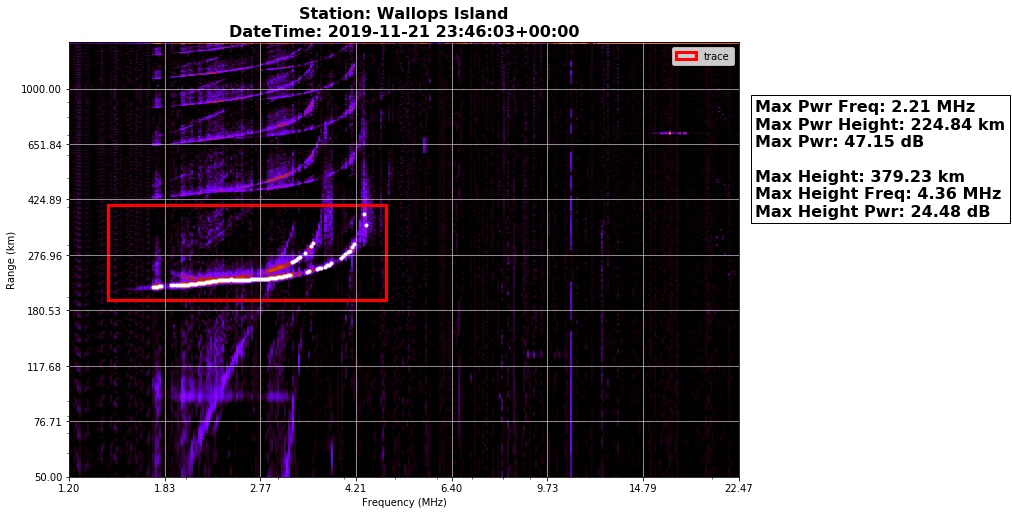

In [49]:
fig = plt.figure(figsize=(12,8))
ax = fig.subplots(1,1)

ax.plot(mp['freq'], mp['rng'], '.', color='white')
show_objects(vip, objs, ax=ax, colorbar=False)

add_pwrstats_ax(ax, mp)

### Old Max Power Code
```
def max_pwr(self, obj):
    snr, freq, rng = self.get_objcontents(obj['rngfreq']['indices'])
    max_pwr_i = snr.argmax(axis=1)
    
    #range at which max power occurs for each freq
    max_pwr_rng = rng[max_pwr_i]
    
    # the actual max power values as a vector
    max_pwr = snr[np.arange(len(freq)), max_pwr_i]
    
    max_pwr_freq_i, max_pwr_rng_i = np.unravel_index(snr.argmax(), snr.shape)
    
    max_pwr_dict = {'freq': freq, 'rng':max_pwr_rng, 'max_pwr':max_pwr,
                   'max_pwr_freq': freq[max_pwr_freq_i], 'max_pwr_rng': rng[max_pwr_rng_i],
                   'max_pwr_val': snr[max_pwr_freq_i, max_pwr_rng_i]}
    
    return max_pwr_dict
 ``` 

In [33]:
def max_pwr(self, obj, min_pwr=20.0):
    snr, freq, rng = self.get_objcontents(obj['rngfreq']['indices'])
    max_pwr = snr.max(axis=1)
    max_pwr_i = snr.argmax(axis=1) # index into the rng vector
    over_thresh = max_pwr >= min_pwr # the freqs at which the max power exceeds min_pwr
     
    max_pwr_freq_i, max_pwr_rng_i = np.unravel_index(snr.argmax(), snr.shape)
    
    max_pwr_dict = {'freq': freq[over_thresh], 'rng':rng[max_pwr_i][over_thresh], 'max_pwr':max_pwr[over_thresh],
                   'max_pwr_freq': freq[max_pwr_freq_i], 'max_pwr_rng': rng[max_pwr_rng_i],
                   'max_pwr_val': max_pwr[over_thresh].max()}
    
    return max_pwr_dict
    

In [34]:
i=14

vip = vp(os.path.join('netcdf',test_file_list[i]+'.NGI'))
ann = ad.annotationtodict(test_file_list[i],'resnet_train')
objs = vip.get_objects(detection_model, thresh=0.5)
mp = max_pwr(vip, objs[0])

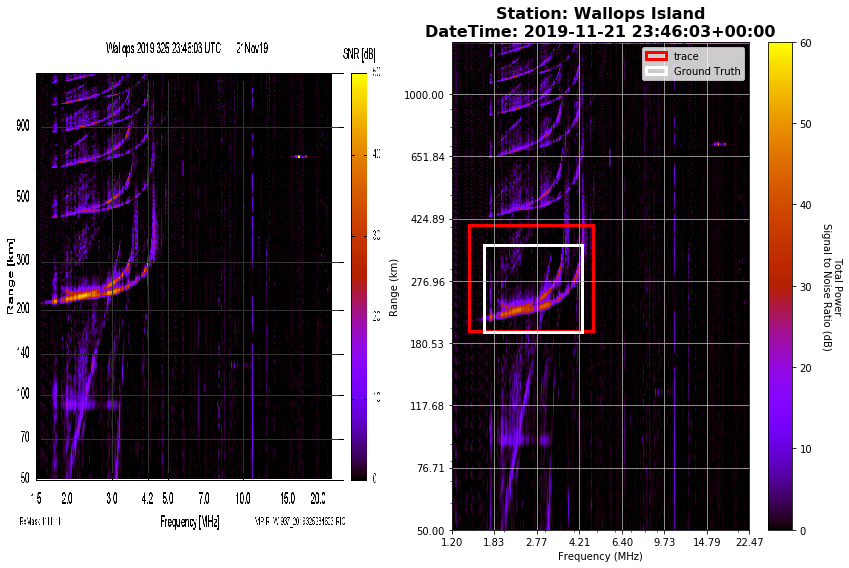

In [35]:
fig = plt.figure(figsize=(12,8), frameon=False)
ax = fig.subplots(1,2)

image = plt.imread(os.path.join('images_png',test_file_list[i]+'_SNR.PNG'))
ax[0].imshow(image, aspect='auto')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
for f in ['top','right','bottom','left']:
    ax[0].spines[f].set_visible(False)

show_objects(vip, objs, true_bbox=ann['bndbox'], ax=ax[1])

plt.tight_layout()

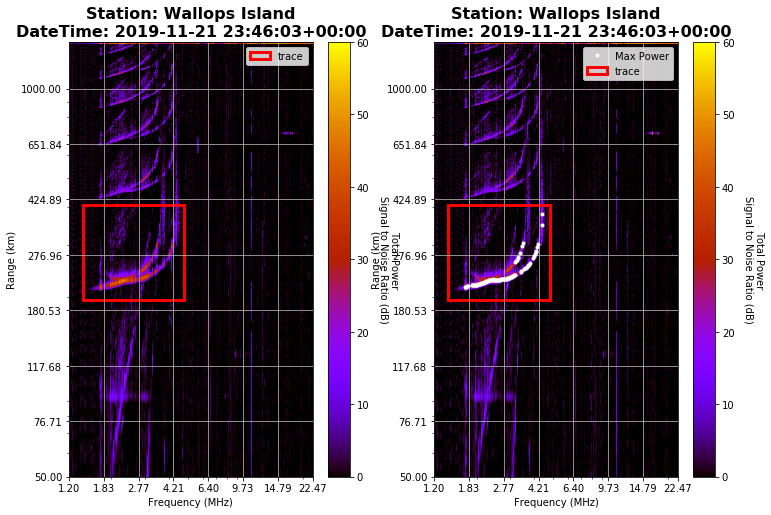

In [36]:
fig = plt.figure(figsize=(12,8), frameon=False)
ax = fig.subplots(1,2)

show_objects(vip, objs, ax=ax[0])

ax[1].plot(mp['freq'], mp['rng'], '.', color='white', label='Max Power')
show_objects(vip, objs, ax=ax[1])




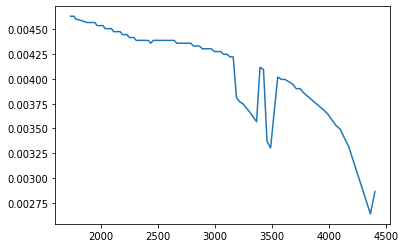

In [37]:
plt.plot(mp['freq'], 1/mp['rng'])

In [38]:
from sklearn.linear_model import LinearRegression

In [39]:
reg = LinearRegression().fit(mp['freq'].reshape((-1,1)), 1/mp['rng'])

In [40]:
reg.coef_

array([-5.167832e-07], dtype=float32)

In [41]:
reg.intercept_

0.005637141

In [42]:
fitted=reg.predict(mp['freq'].reshape((-1,1)))

In [43]:
fitted.shape

(90,)

In [44]:
(-reg.intercept_/reg.coef_[0])

10908.136

In [45]:
import matplotlib.lines as mlines

def critfreq_fit(self, obj, ax):
    mp = max_pwr(self, obj)
    
    X = mp['freq'].reshape(-1,1)
    Y = 1.0/mp['rng']
    reg = LinearRegression().fit(X,Y)
    fitted = reg.predict(X)
    
    critfreq = (-1.0*reg.intercept_)/reg.coef_[0]
    
    ax.plot(X, fitted, color='red', linewidth=5, label='fitted')
    ax.scatter(X, Y, marker='o', color='blue', label='1/h\'(f)')

    
    ax.set_title(f'Station: {vip.station}\nDateTime: {vip.obs_time}',
                fontdict={'size':16, 'weight':'bold'})
    
    ax.set_xlabel('Freqency (kHz)')
    ax.set_ylabel('Inverse Virtual Height')
    
    textstr = 'Critical Freq\n %.2f kHz\n\n $R^2$: %.4f' %(critfreq,reg.score(X,Y))
    ax.text(1.05, 0.75, textstr,transform=ax.transAxes,
           fontdict={'size':16, 'weight':'bold'},
           bbox={'edgecolor':'black', 'facecolor':'none'})
    ax.legend(fontsize='large')
    ax.grid()
    

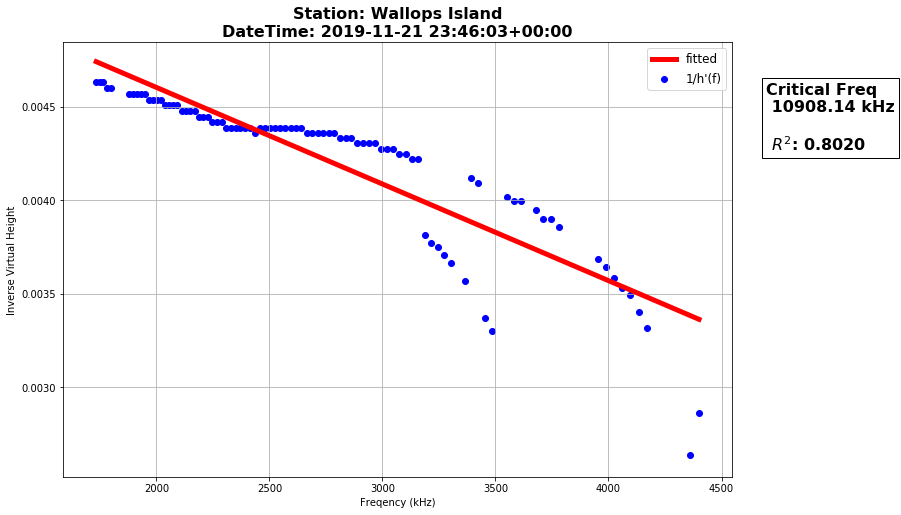

In [46]:
fig = plt.figure(figsize=(12,8))
ax = fig.subplots(1,1)
critfreq_fit(vip,objs[0], ax)

In [47]:
mp.keys()

dict_keys(['freq', 'rng', 'max_pwr', 'max_pwr_freq', 'max_pwr_rng', 'max_pwr_val'])

In [48]:
def add_pwrstats_ax(ax, pwr):
    
    max_pwr_freq = pwr['max_pwr_freq']
    max_pwr_rng = pwr['max_pwr_rng']
    max_pwr = pwr['max_pwr_val']
    
    max_rng = pwr['rng'].max()
    max_rng_i = pwr['rng'].argmax()
    max_rng_freq = pwr['freq'][max_rng_i]
    max_rng_pwr = pwr['max_pwr'][max_rng_i]
    
    textstr = (f'Max Pwr Freq: {max_pwr_freq/1000.0:.2f} MHz'
               f'\nMax Pwr Height: {max_pwr_rng:.2f} km'
               f'\nMax Pwr: {max_pwr:.2f} dB'
               f'\n\nMax Height: {max_rng:.2f} km'
               f'\nMax Height Freq: {max_rng_freq/1000.0:.2f} MHz'
               f'\nMax Height Pwr: {max_rng_pwr:.2f} dB'
              )
    
    ax.text(1.025, 0.60, textstr,transform=ax.transAxes,
           fontdict={'size':16, 'weight':'bold'},
           bbox={'edgecolor':'black', 'facecolor':'none'})
         
    return textstr
    

'Max Pwr Freq: 2.21 MHz\nMax Pwr Height: 224.84 km\nMax Pwr: 47.15 dB\n\nMax Height: 379.23 km\nMax Height Freq: 4.36 MHz\nMax Height Pwr: 24.48 dB'

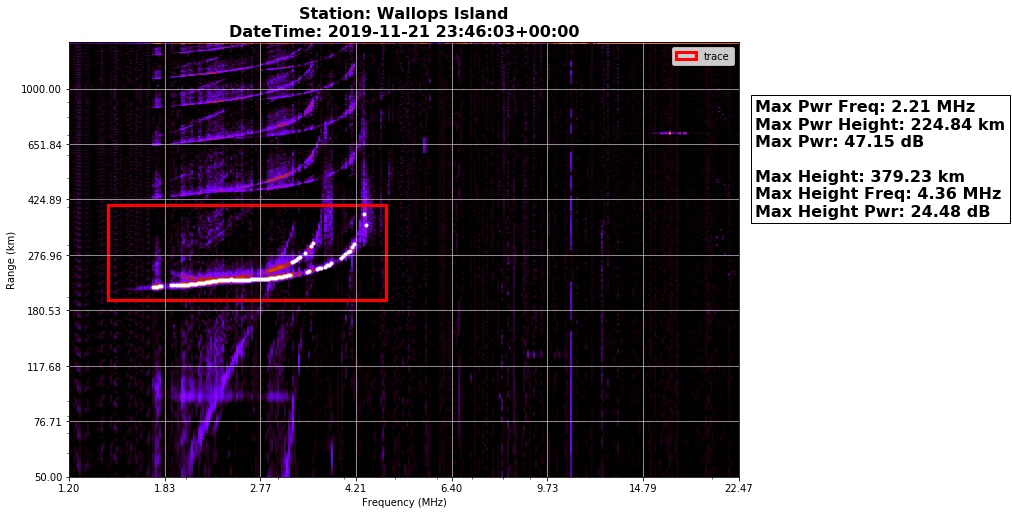

In [49]:
fig = plt.figure(figsize=(12,8))
ax = fig.subplots(1,1)

ax.plot(mp['freq'], mp['rng'], '.', color='white')
show_objects(vip, objs, ax=ax, colorbar=False)

add_pwrstats_ax(ax, mp)

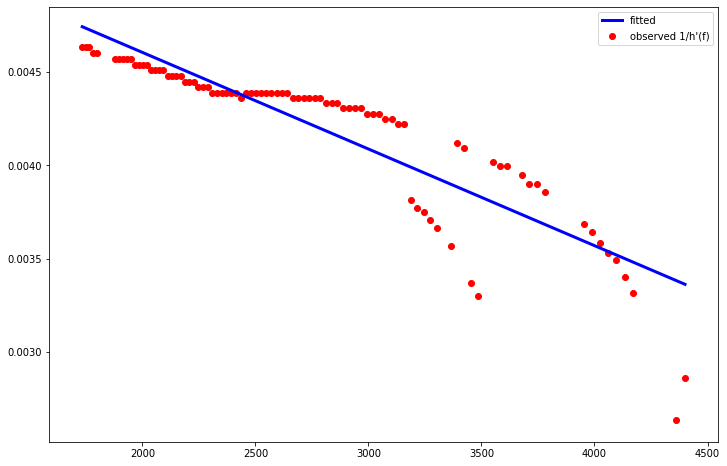

In [48]:
fig = plt.figure(figsize=(12,8))
ax = fig.subplots(1,1)
ax.plot(mp['freq'], fitted, color='blue', label='fitted', lw=3)
ax.scatter(mp['freq'],1/mp['rng'],color='red', label='observed 1/h\'(f)')
ax.legend()

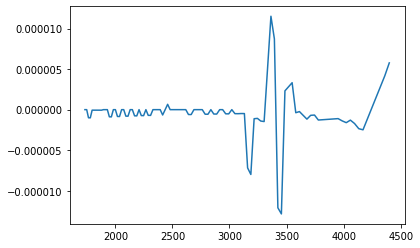

In [49]:
plt.plot(mp['freq'],np.gradient(1/mp['rng'], mp['freq']))

In [50]:
np.gradient(mp['rng'], mp['freq']).max()

0.9512181

code moved to vipir.py
```
def get_objcontents(self, rngfreq_i):
    
    snr = self.snr()
    return (snr[rngfreq_i['minfreq_i']:rngfreq_i['maxfreq_i'],
               rngfreq_i['minrng_i']:rngfreq_i['maxrng_i']],
            self.freq[rngfreq_i['minfreq_i']:rngfreq_i['maxfreq_i']],
            self.rng[rngfreq_i['minrng_i']:rngfreq_i['maxrng_i']])
```

In [ ]:
@ticker.FuncFormatter
def major_formatter(x, pos):
    return "%.2f" % x

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
pcm = ax.pcolormesh(wi937.freq, wi937.rng, wi937.snr().T, cmap='gnuplot')
rngfreq = objs[0]['rngfreq']['coords']
draw_box_on_axis(ax, (rngfreq['minfreq'], rngfreq['minrng']), #origin
                      rngfreq['maxfreq'] - rngfreq['minfreq'], #x-extent
                      rngfreq['maxrng'] - rngfreq['minrng']) #y-extent

#put on the ground truth
#rngfreq = bbox_rngfreq(wi937, bbox)['coords']
#draw_box_on_axis(ax, (rngfreq['minfreq'], rngfreq['minrng']), #origin
#                      rngfreq['maxfreq'] - rngfreq['minfreq'], #x-extent
#                      rngfreq['maxrng'] - rngfreq['minrng'],   #y-extent
#                      color = 'white')
ax.plot(freq, rng[max_pwr_i],'.', color='white')

pwr_max_freq_i, pwr_max_rng_i = np.unravel_index(snr.argmax(), snr.shape)
ax.plot(freq[pwr_max_freq_i], rng[pwr_max_rng_i], 'o', markersize=20,markeredgewidth=20,color='black')

ax.set_title(f'Station: {wi937.station}, DateTime: {wi937.obs_time}')
ax.set_ylabel('Range (km)')
ax.set_xlabel('Frequency (KHz)')

ax.set_xscale('log')
ax.grid()

ax.set_xticks(np.logspace(np.log10(wi937.minfreq), np.log10(wi937.maxfreq),8))
ax.xaxis.set_major_formatter(major_formatter)

cbar=fig.colorbar(pcm, ax=ax)
cbar.set_label('Total Power\nSignal to Noise Ratio (dB)', rotation=270, labelpad=30)

In [51]:
import pandas as pd

In [52]:
test_file_df = pd.DataFrame({'Station':[x[0:5] for x in test_file_list],'Filename':test_file_list})

In [53]:
test_file_df.Station.unique()

array(['WI937', 'SJJ18', 'JV433', 'IV437'], dtype=object)

In [54]:
test_file_df.query('Station==\'WI937\'')

,Station,Filename
0,WI937,WI937_2020013112402
1,WI937,WI937_2019308022503
3,WI937,WI937_2019320085803
6,WI937,WI937_2019327130203
9,WI937,WI937_2020016101802
10,WI937,WI937_2019173141402
13,WI937,WI937_2019252225302
14,WI937,WI937_2019325234603
18,WI937,WI937_2020016105603
19,WI937,WI937_2019237021003


In [55]:
i=9

vip = vp(os.path.join('netcdf',test_file_list[i]+'.NGI'))
ann = ad.annotationtodict(test_file_list[i],'resnet_train')
objs = vip.get_objects(detection_model)
mp = max_pwr(vip, objs[0])

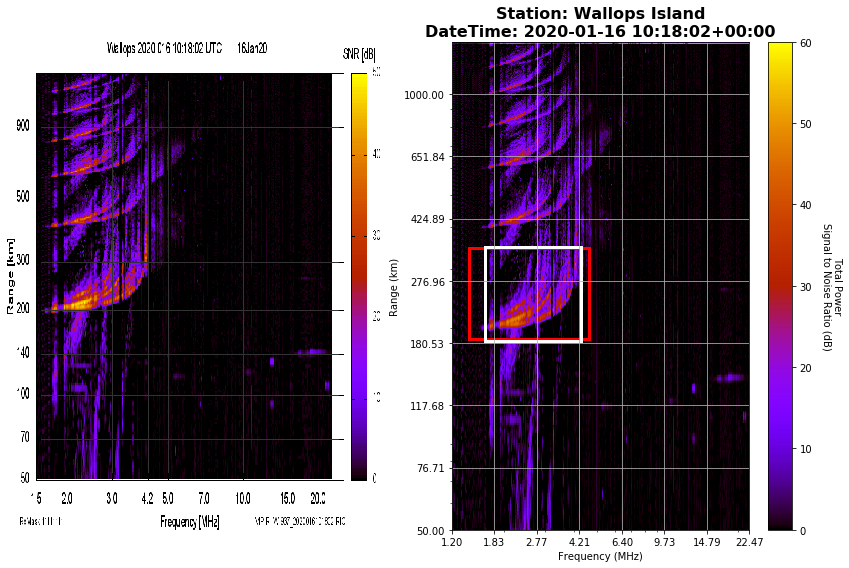

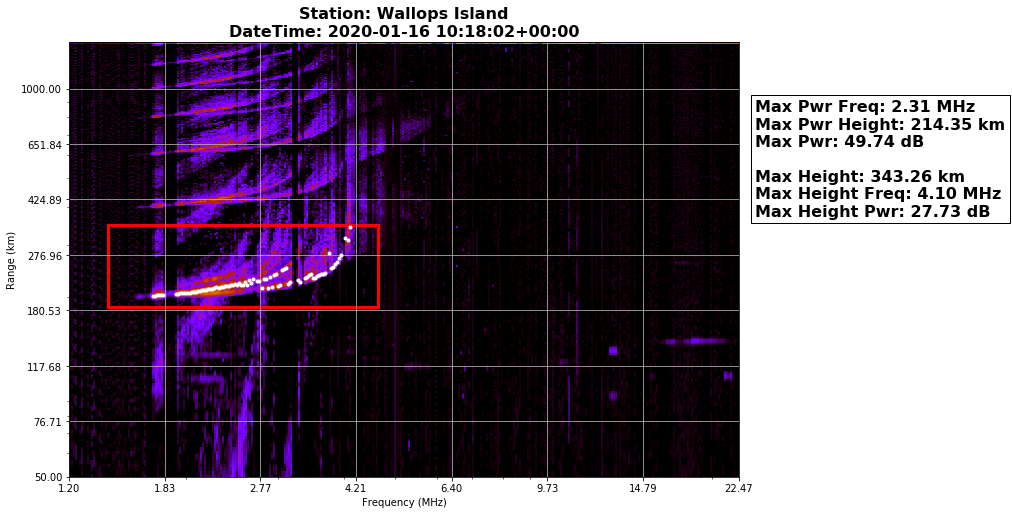

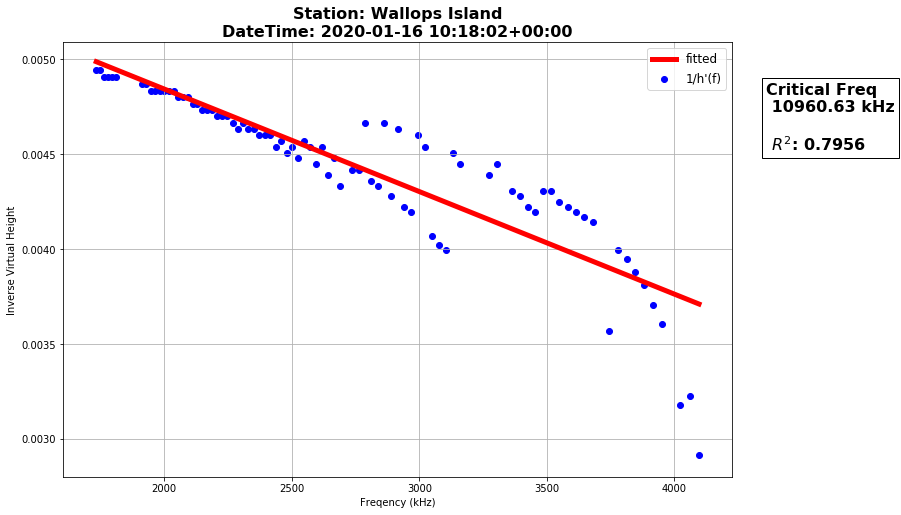

In [56]:
fig = plt.figure(figsize=(12,8), frameon=False)
ax = fig.subplots(1,2)

image = plt.imread(os.path.join('images_png',test_file_list[i]+'_SNR.PNG'))
ax[0].imshow(image, aspect='auto')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
for f in ['top','right','bottom','left']:
    ax[0].spines[f].set_visible(False)

show_objects(vip, objs, true_bbox=ann['bndbox'], ax=ax[1])

plt.tight_layout()

fig = plt.figure(figsize=(12,8))
ax = fig.subplots(1,1)

ax.plot(mp['freq'], mp['rng'], '.', color='white')
show_objects(vip, objs, ax=ax, colorbar=False)

add_pwrstats_ax(ax, mp)

plt.show()

fig = plt.figure(figsize=(12,8))
ax = fig.subplots(1,1)
critfreq_fit(vip,objs[0], ax)
plt.show()

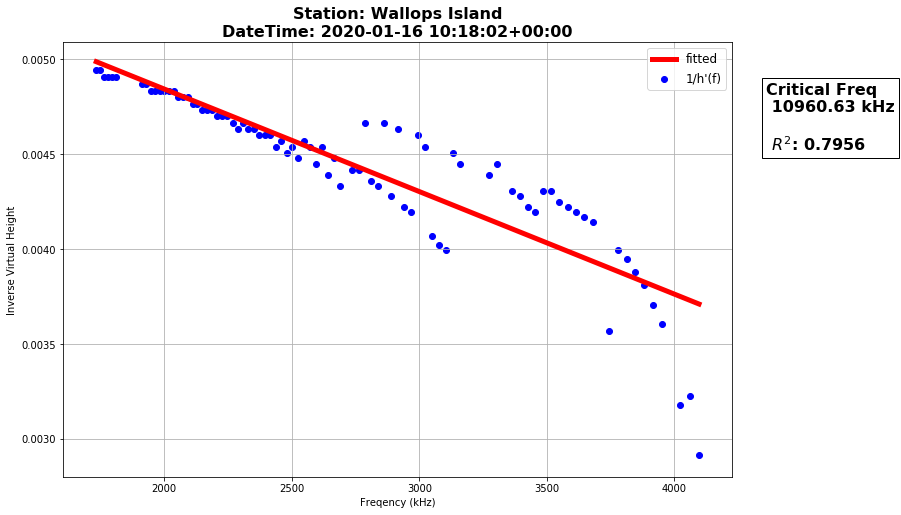

In [57]:
fig = plt.figure(figsize=(12,8))
ax = fig.subplots(1,1)
critfreq_fit(vip,objs[0], ax)

In [58]:
i=38

vip = vp(os.path.join('netcdf',test_file_list[i]+'.NGI'))
ann = ad.annotationtodict(test_file_list[i],'resnet_train')
objs = vip.get_objects(detection_model)
mp = max_pwr(vip, objs[0])
len(objs)

1

'Max Pwr Freq: 3.02 MHz\nMax Pwr Height: 256.32 km\nMax Pwr: 47.36 dB\n\nMax Height: 454.18 km\nMax Height Freq: 5.31 MHz\nMax Height Pwr: 28.47 dB'

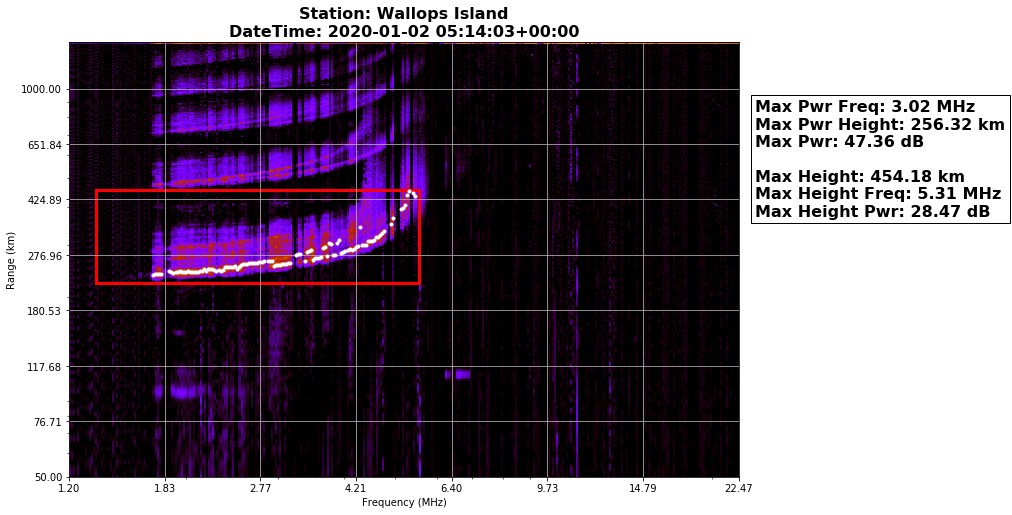

In [59]:
fig = plt.figure(figsize=(12,8))
ax = fig.subplots(1,1)

ax.plot(mp['freq'], mp['rng'], '.', color='white')
show_objects(vip, objs, ax=ax, colorbar=False)

add_pwrstats_ax(ax, mp)

In [ ]:
test_file_list

In [60]:
fname = 'SJJ18_2019365223001'

In [61]:
i=-2

vip = vp(os.path.join('netcdf',fname+'.NGI'))
ann = ad.annotationtodict(fname,'resnet_train')
objs = vip.get_objects(detection_model)
mp = max_pwr(vip, objs[0])
len(objs)

1

'Max Pwr Freq: 3.20 MHz\nMax Pwr Height: 227.84 km\nMax Pwr: 44.38 dB\n\nMax Height: 361.25 km\nMax Height Freq: 5.42 MHz\nMax Height Pwr: 31.28 dB'

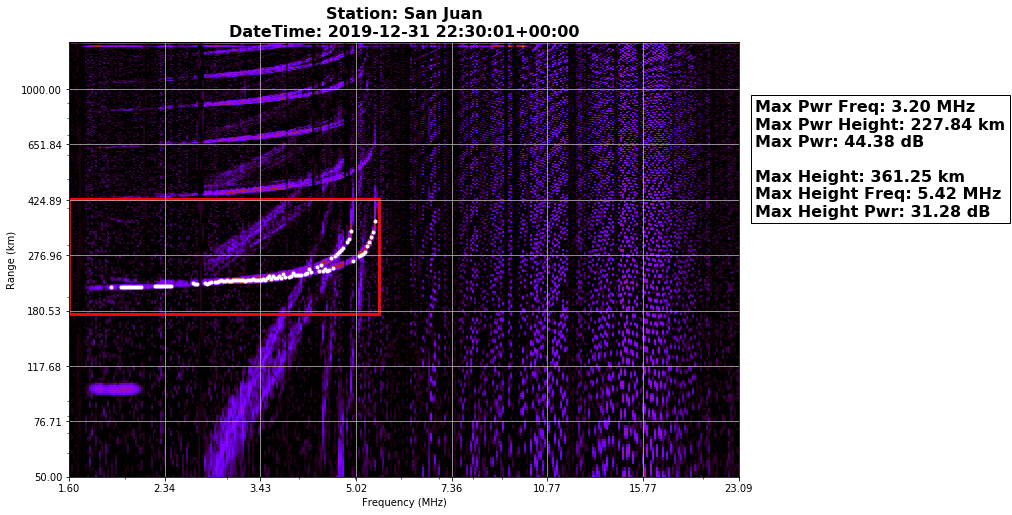

In [62]:
fig = plt.figure(figsize=(12,8))
ax = fig.subplots(1,1)

ax.plot(mp['freq'], mp['rng'], '.', color='white')
show_objects(vip, objs, ax=ax, colorbar=False)

add_pwrstats_ax(ax, mp)

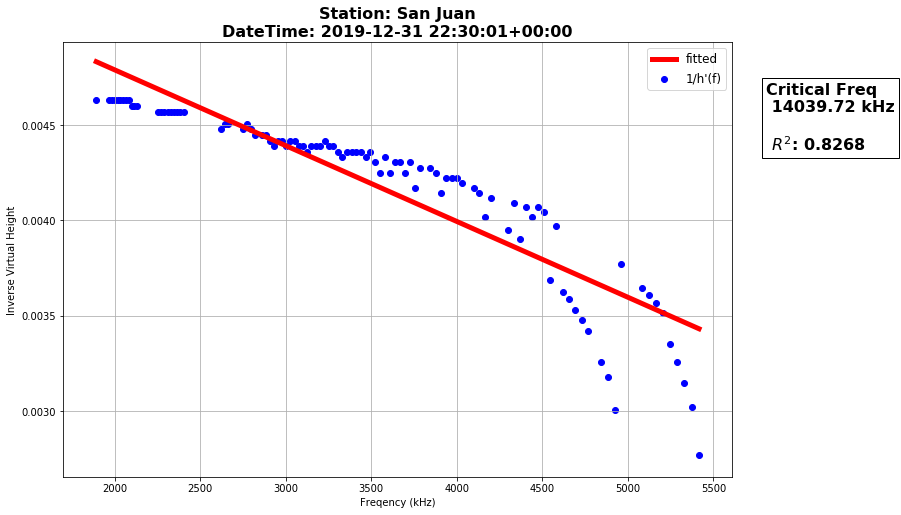

In [63]:
fig = plt.figure(figsize=(12,8))
ax = fig.subplots(1,1)
critfreq_fit(vip,objs[0], ax)

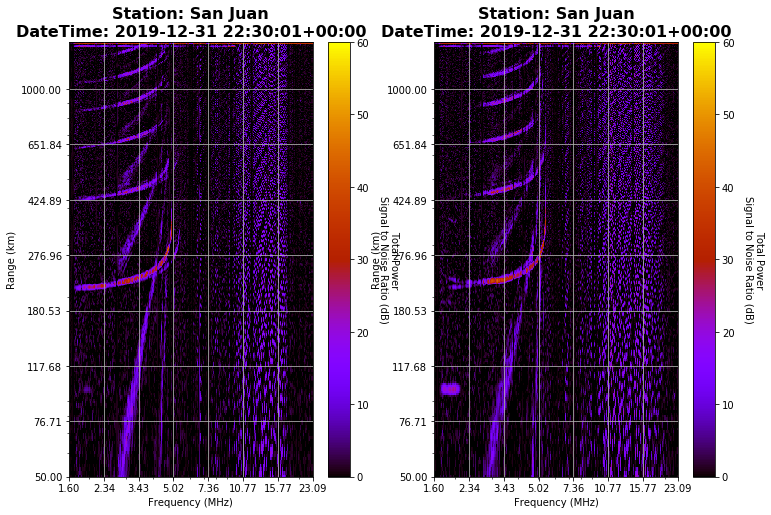

In [71]:
fig = plt.figure(figsize=(12,8))
ax = fig.subplots(1,2)
#show_objects(vip,[],ax=ax[0],which='total_power', colorbar=False)
show_objects(vip,[],ax=ax[0],which='O_mode_power', colorbar=True)
show_objects(vip,[],ax=ax[1],which='X_mode_power', colorbar=True)